In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.lines as mlines

import pymc as mc

import pandas as pd
import numpy as np

import datetime

from scipy.signal import savgol_filter

In [2]:
import vpfits

# VPfits

The VPfits module contains a class, `VPfit`, that carries out most of the heavy lifting. First we create an instance of this class.

In [3]:
vpfit = vpfits.VPfit()

## Mock Spectra

`VPfit` contains a function for creating mock absoprtion profiles, `mock_absorption`. Just tell it how many features you wish to include. It returns a dataframe, `clouds`, containing each feature, and an array of wavelength values. It can also plot the profile.

If you wish to create mock voigt profiles, set the `voigt` parameter to true.

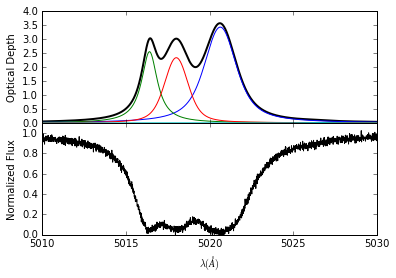

In [4]:
n = 4

#clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True)

clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True, voigt=True)

The plot shows the profile with added noise, but right now the function doesn't return this composite noisy profile, so we recreate it as `flux_array`.

In [5]:
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))

noise_vector = [onesigmaerror]*len(noise)
flux_array = vpfit.Absorption(sum(clouds['tau'])) + noise
flux_array[flux_array < 0] = 0

## Find Local Minima

In [6]:
window=101

local_minima = vpfit.find_local_minima(flux_array, window=window)

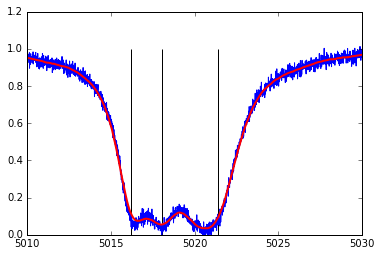

In [7]:
pylab.plot(wavelength_array, flux_array)
pylab.plot(wavelength_array, savgol_filter(flux_array, window, 1), 'red', lw=2)

local_minima = vpfit.find_local_minima(flux_array)

pylab.vlines(wavelength_array[local_minima], 0, 1)

## Fitting

To fit, initialise the model with `n` profiles, calculate the MAP estimate, then run the MCMC.

If you wish to fit Voigt profiles, set the `voigt` flag to True (be aware that the VPfit Voigt profile implementation consists of an extra parameter relative to the Gaussian, and will take longer to converge, especially for complicated profiles).

In [8]:
vpfit.initialise_model(wavelength_array, flux_array, n, local_minima, voigt=True)

Initialising Voigt profile components.


In [9]:
vpfit.map_estimate()

vpfits.py:85: RuntimeWarning: overflow encountered in exp
  return np.exp(-arr)


In [10]:
vpfit.mcmc_fit(iterations=10000, burnin=5000)

Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 114.8 sec
Took: 0:01:54.764263  to finish.


Our `VPfit` instance, `vpfit`, now contains the fitted profile components.

## Convergence

We can assess whether the chain has converged using a number of different formal diagnostics provided by PyMC. 

*The Geweke diagnostic often fails with an opaque error, especially if the chains are very far from convergence.*

In [23]:
alpha_scores = mc.geweke(vpfit.mcmc, intervals=20)

mc.Matplot.geweke_plot(alpha_scores)

LinAlgError: Singular matrix

In [24]:
rl_convergence = mc.raftery_lewis(vpfit.mcmc, q=0.995, r=0.05, verbose=True)
rl_convergence


Diagnostic for xexp_3 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

31 iterations to be discarded at the beginning of the simulation (burn-in).

55 subsequent iterations required.

Thinning factor of 4 required to produce an independence chain.

Diagnostic for est_G_3 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

9 iterations to be discarded at the beginning of the simulation (burn-in).

22 subsequent iterations required.

Thinning factor of 4 required to produce an independence chain.

Diagnostic for sd ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a fi

{'est_G_0': (8, 1, 35, 68, 6),
 'est_G_1': (8, 1, 13, 28, 3),
 'est_G_2': (8, 1, 15, 34, 6),
 'est_G_3': (8, 1, 9, 22, 4),
 'est_L_0': (8, 1, 31, 28, 3),
 'est_L_1': (8, 1, 9, 22, 3),
 'est_L_2': (8, 1, 35, 34, 5),
 'est_L_3': (8, 1, 66, 116, 9),
 'est_centroid_0': (8, 1, 22, 43, 4),
 'est_centroid_1': (8, 1, 12, 27, 2),
 'est_centroid_2': (8, 1, 66, 116, 6),
 'est_centroid_3': (8, 1, -2147483648, -2147483648, 1),
 'sd': (8, 1, 21, 26, 3),
 'xexp_0': (8, 1, 20, 35, 4),
 'xexp_1': (8, 1, 16, 31, 4),
 'xexp_2': (8, 1, 28, 44, 6),
 'xexp_3': (8, 1, 31, 55, 4)}

## Model Selection

We can query some features of the fit useful for model selection, such as the Maximum A Posteriori (MAP) Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC).

In [25]:
print vpfit.MAP.BIC
print vpfit.MAP.AIC

-1537.76753748
-1632.98287929


We also have model selection metrics from the MCMC

In [26]:
print vpfit.mcmc.BPIC
print vpfit.mcmc.DIC

-9916.09132226
-9883.22750349


The class instance also has functions for calculating both the $\chi^2$ and the reduced chi-squared, $\chi_{r}^{2}$.

In [27]:
vpfits.VPfit.Chisquared(vpfit.total.value, flux_array, noise_vector)

2160.755904220222

In [28]:
vpfits.VPfit.ReducedChisquared(vpfit.total.value, flux_array, noise_vector, len(vpfit.estimated_variables))

1.082543038186484

## Plotting

Finally, we can also plot the fit, with residuals. The fitted components and actual components can be directly compared.

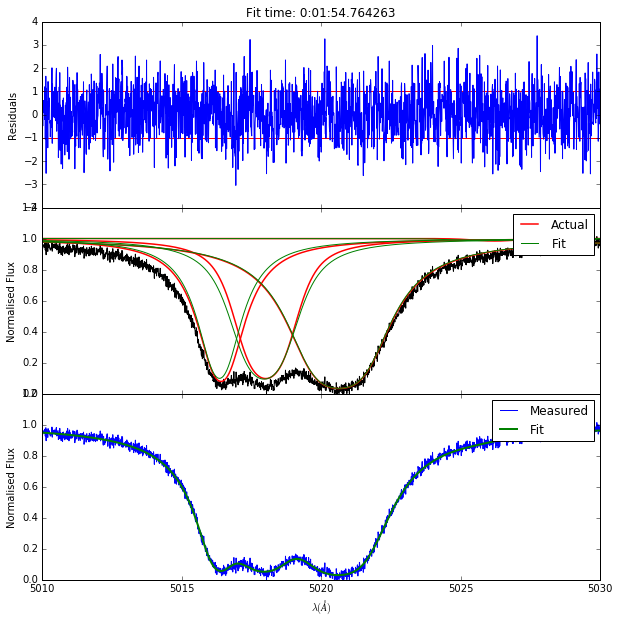

In [11]:
vpfit.plot(wavelength_array, flux_array, clouds, n=n)

# Region Detection

Regions are detected based on a detection threshold of 4 sigma. The number of pixels needed below the threshold to divide regions is set with `buffer`, and the minimum width of a region is set with `min_region_width` in pixels.

The `compute_detection_regions` function outputs a numpy array of the start and end wavelengths of each region.

In [12]:
min_region_width = 5
regions = vpfits.compute_detection_regions(wavelength_array, flux_array, noise_vector, 
                                           min_region_width = min_region_width)

print regions

Computing detection regions...
Found 4 detection regions.
[[ 5010.    5027.77]
 [ 5027.71  5029.17]
 [ 5029.11  5029.6 ]
 [ 5029.54  5029.91]]


We then construct arrays containing the delimiting pixels and wavelength values for each region

In [13]:
region_arrays = []
region_pixels = []

for region in regions:
    
    start = np.where(wavelength_array==region[0])[0][0]
    end = np.where(wavelength_array==region[1])[0][0]
    
    region_pixels.append([start, end])
    region_arrays.append([wavelength_array[start:end], flux_array[start:end]])

We can now plot each region.

In [14]:
def plot_bracket(x, dir):
    height = .2
    arm_length = 0.2
    pylab.plot((x, x), (1-height/2, 1+height/2), color='magenta')
    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length
    pylab.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    pylab.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

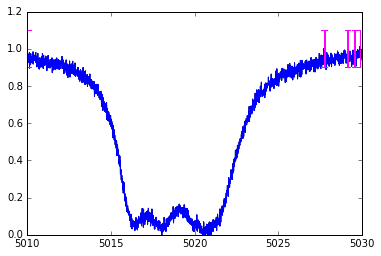

In [15]:
pylab.plot(wavelength_array, flux_array, c='black')

for arr in region_arrays:
    pylab.plot(arr[0], arr[1], color='blue')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')
    
pylab.show()

## Finding the right number of profiles

In a complicated spectrum, knowing how many components there are can be difficult. `VPfits` can perform model selection on two fits with different numbers of profiles to determine which is the best.

Below is an early implementation using the Bayesian Information Criterion (BIC) as a threshold.

Initialising Gaussian profile components.
n:  2
Initialising Gaussian profile components.
Fit 1 BIC:  -1861.18000795 , Fit 2 BIC:  -2924.06538517
Fit 1 CS: 8.98093764562e-06 | Fit 2 CS: 3.90411239249e-08
BIC Ratio:  0.636504237352
n:  3
Initialising Gaussian profile components.
Fit 1 BIC:  -2924.06538517 , Fit 2 BIC:  -2948.71474772
Fit 1 CS: 3.90411239249e-08 | Fit 2 CS: 3.10139600654e-08
BIC Ratio:  0.991640641886
n:  4
Initialising Gaussian profile components.
Fit 1 BIC:  -2948.71474772 , Fit 2 BIC:  -2870.44209873
Fit 1 CS: 3.10139600654e-08 | Fit 2 CS: 4.17835614447e-08
BIC Ratio:  1.02726849952
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 14.8 sec
Took: 0:00:14.806366  to finish.


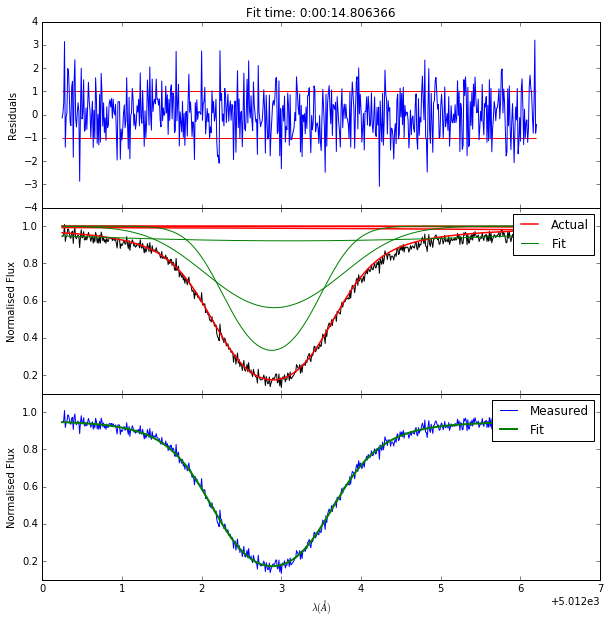

Initialising Gaussian profile components.
n:  2
Initialising Gaussian profile components.
Fit 1 BIC:  -1811.08209573 , Fit 2 BIC:  -1923.36451451
Fit 1 CS: 0.00219277496223 | Fit 2 CS: 0.00157036774076
BIC Ratio:  0.941621872543
n:  3
Initialising Gaussian profile components.
Fit 1 BIC:  -1923.36451451 , Fit 2 BIC:  -5358.36050423
Fit 1 CS: 0.00157036774076 | Fit 2 CS: 2.39606398129e-07
BIC Ratio:  0.358946456288
n:  4
Initialising Gaussian profile components.
Fit 1 BIC:  -5358.36050423 , Fit 2 BIC:  -4306.11279016
Fit 1 CS: 2.39606398129e-07 | Fit 2 CS: 3.29645055707e-06
BIC Ratio:  1.24436139166
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 24.5 sec
Took: 0:00:24.472829  to finish.


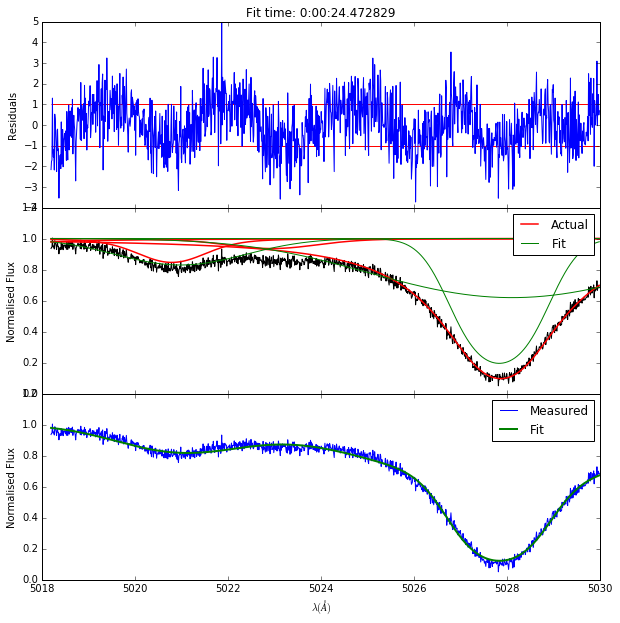

In [23]:
fits = []

for i in range(len(region_arrays)):
    
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelengths, fluxes, n)
    vpfit_2.map_estimate()

    while((r < 1) or (vpfits.VPfit.Chisquared(vpfit_2.total.value, fluxes, vpfit_2.std_deviation) > 1.5)):

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n)
        vpfit_2.map_estimate()

        print "Fit 1 BIC: ", vpfit_1.MAP.BIC, ", Fit 2 BIC: ", vpfit_2.MAP.BIC
        
        print "Fit 1 CS:", vpfits.VPfit.Chisquared(vpfit_1.total.value, fluxes, vpfit_1.std_deviation), "| Fit 2 CS:", \
            vpfits.VPfit.Chisquared(vpfit_2.total.value, fluxes, vpfit_2.std_deviation)
            
        print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC

        r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    n -= 1
    #print "n (final): ", n
    
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    vpfit_1.plot(wavelengths, fluxes, clouds, n, start_pix=start, end_pix=end)

Finally, we can plot the detection regions and the fitted profiles over the entire spectrum.

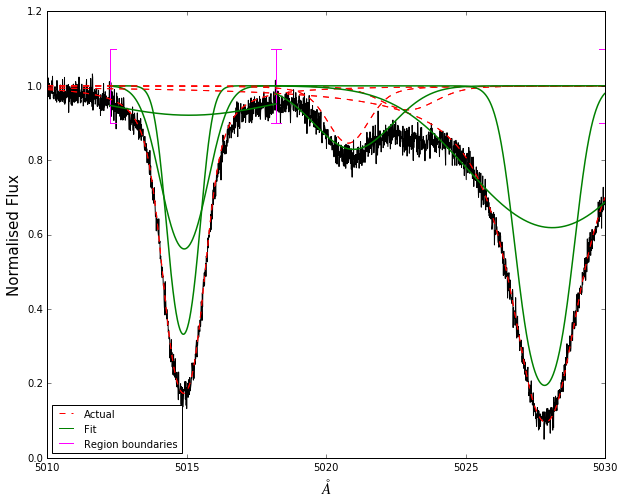

In [25]:
fig, ax = pylab.subplots(figsize=(10,8))

ax.plot(wavelength_array, flux_array, c='black')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')

for i in range(len(fits)):
    fit = fits[i]
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    for c in range(len(clouds)):
        ax.plot(wavelength_array, fit.Absorption(clouds.ix[c]['tau']), color="red", ls='--')
        
    for prof in fit.estimated_profiles:
        ax.plot(wavelengths, fit.Absorption(prof.value), color='green', lw=1.5)
        

handles = [mlines.Line2D([], [], color='red', label='Actual', ls='--'), mlines.Line2D([], [], color='green', label='Fit'),
          mlines.Line2D([], [], color='magenta', label='Region boundaries')]

ax.legend(handles=handles, prop={'size':10}, loc='best')

ax.set_xlabel('$\AA$', size=15)
ax.set_ylabel('Normalised Flux', size=15)